In [1]:
import ice
import ice_with_dask as ica

from sklearn import linear_model, datasets
import xgboost as xgb
import pandas as pd
import dask.array as da
import dask.distributed
import numpy as np

%load_ext autoreload
%autoreload 2

[11:06:47] ======== Monitor (0): Learner ========
[11:06:47] ======== Monitor (0): GBTree ========
[11:06:47] ======== Monitor (0): TreePruner ========
[11:06:47] ======== Monitor (0): QuantileHistMaker ========
[11:06:47] INFO: ../src/gbm/gbtree.cc:177: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[11:06:47] INFO: ../src/gbm/gbtree.cc:177: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[11:06:47] ======== Monitor (0): HostSketchContainer ========
[11:06:47] AllReduce: 0.000134s, 1 calls @ 134us

[11:06:47] MakeCuts: 0.000236s, 1 calls @ 236us

[11:06:47] PushRowPage: 5e-05s, 1 calls @ 50us

[11:06:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:06:47] INFO: ../src/gbm/gbtree.cc:177: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[11:06:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning 

<AxesSubplot:>

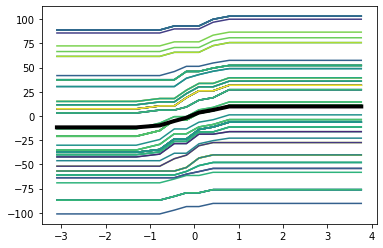

In [41]:
X, y, coef = datasets.make_regression(1000, 3, noise=0.1, coef=True)
reg = xgb.XGBRegressor(n_estimators = 10, max_depth = 3, learning_rate = 0.1,
                       objective = 'reg:squarederror', booster = 'gbtree',
                       tree_method = 'hist', gamma = 0, min_child_weight = 30,
                       verbosity = 3)
reg.fit(X,y)
print(reg.score(X,y))
data = pd.DataFrame(X, columns = [f'X_{i}' for i in range(X.shape[1])])
ice_data = ice.ice(data, 'X_0',
                   reg.predict, num_grid_points=10)
ice.ice_plot(ice_data, frac_to_plot = 0.1, color_by = 'X_1', plot_pdp = True, pdp_kwargs = {'lw': 4, 'color': 'k'})

In [6]:
cluster = dask.distributed.LocalCluster()
client = dask.distributed.Client(cluster)

/lustre/haven/user/ywang254/conda_env_test/dask_ml/lib/python3.9/contextlib.py:126: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)
/lustre/haven/user/ywang254/conda_env_test/dask_ml/lib/python3.9/contextlib.py:126: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)
/lustre/haven/user/ywang254/conda_env_test/dask_ml/lib/python3.9/contextlib.py:126: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(se

[11:06:33] ======== Monitor (0): Learner ========
[11:06:33] ======== Monitor (0): GBTree ========
[11:06:33] ======== Monitor (0): TreePruner ========
[11:06:33] ======== Monitor (0): QuantileHistMaker ========


[11:06:34] task [xgboost.dask]:tcp://127.0.0.1:32796 got new rank 0
[11:06:34] INFO: ../src/gbm/gbtree.cc:177: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[11:06:34] INFO: ../src/gbm/gbtree.cc:177: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[11:06:34] ======== Monitor (0): HostSketchContainer ========
[11:06:34] AllReduce: 0.000121s, 1 calls @ 121us

[11:06:34] MakeCuts: 0.000174s, 1 calls @ 174us

[11:06:34] PushRowPage: 0.000122s, 1 calls @ 122us

[11:06:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:06:34] INFO: ../src/gbm/gbtree.cc:177: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[11:06:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:06:34] INFO: ../src/gbm/gbtree.cc:177: Tree method is selected to be 'hist', which uses

0.6967101075034815


<AxesSubplot:>

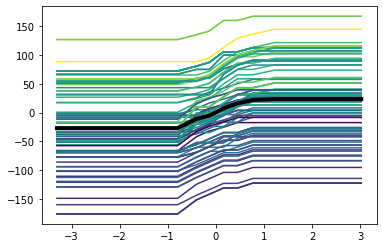

In [40]:
X = da.array(X)
y = da.array(y)
reg = xgb.dask.DaskXGBRegressor(n_estimators = 10, max_depth = 3, learning_rate = 0.1,
                                objective = 'reg:squarederror', booster = 'gbtree',
                                tree_method = 'hist', gamma = 0, min_child_weight = 30,
                                verbosity = 3)
reg.client = client
reg.fit(X,y)
print(reg.score(X,y))
ice_y, orig_column, x_s = ica.ice(X, 0, reg.predict, num_grid_points=10)
ica.ice_plot(ice_y, orig_column, x_s, color_by = X[:,1], plot_pdp = True, pdp_kwargs = {'lw': 4, 'color': 'k'})